# Homework 2 (HW2)
By the end of this homework, we expect you to be able to:

- Preprocess data and make it amenable to statistical analysis and machine learning models;
- Train and test out-of-the-box machine learning models in Python;
- Carry out simple multivariate regression analyses;
- Use techniques to control for covariates;
- Conduct an observational study and reason about its results.

---

- Homework release: Fri 17 Nov 2023	

- **Homework Due**: Fri 01 Dec 2023, 23:59	

- Grades released: Mon 11 Dec 2023	


---

## Some rules
1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you may do so, but must justify your choice.

2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you don’t change any of the files.)

3. Be sure to provide a concise textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice.

4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation **(in markdown)**.

5. Back up any hypotheses and claims with data, since this is an important aspect of the course.

6. Please write all your comments in **English**, and use meaningful variable names in your code. Your repo should have a single notebook (plus the required data files) in the master/main branch. **If there are multiple notebooks present, we will not grade anything.**

7. We will **not run your notebook for you!** Rather, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.

8. In continuation to the previous point, interactive plots, such as those generated using the `plotly` package, should be strictly avoided!

9. Make sure to print results and/or dataframes that confirm you have properly addressed the task.


---

In [21]:
import pandas as pd
import numpy as np
import json

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# regression / matching
import statsmodels.formula.api as smf
import networkx as nx
import statsmodels.graphics.regressionplots as smg

# machine lerning
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder

# misc
from scipy import stats



pd.set_option('display.max_columns', 500)

## Context

After two years, the EPFL Baseball Club is broke. The new Dean transferred all funds to EPFL's new poster child: its super-competitive Pétanque club. After struggling so much to learn about baseball, you have unfortunately been laid off...

*(...) 1 month after, you manage to get another job (!) (...)*

Congratulations! You have just been hired as a data scientist at the Association for Computational Linguistics (ACL), a professional organization for people working on natural language processing. The ACL organizes several of the top conferences and workshops in the field of computational linguistics and natural language processing.
Your boss, Dr. Tiancheng, knows of your expertise in observational studies and asks you to investigate a question that’s been bothering everyone who has ever submitted a paper to a conference: should I spend time on writing rebuttals?



---

## Rebuttals, conferences, and getting your papers accepted

Rebuttals in ACL (Association for Computational Linguistics) conferences and in many other academic conferences are an important part of the peer-review process. They allow authors of submitted papers to respond to the reviews and comments provided by the reviewers before a final decision is made regarding the acceptance of the paper. Here's how the rebuttal process typically works in ACL conferences:

- Paper Submission: Authors submit their research papers to the ACL conference for review. These papers present novel research findings in computational linguistics, natural language processing, and related areas.
- Peer Review: The papers undergo a peer-review process after the initial submission. The program committee or reviewers are experts in the field who evaluate the papers based on their quality, significance, novelty, methodology, and other relevant criteria. They provide comments and scores for each paper.
- Rebuttal Period: After receiving the reviews, authors are given a specific period (usually around a week) to write a rebuttal. The rebuttal is a formal response to the reviewers' comments. It allows authors to clarify misunderstandings, address concerns, and provide additional information to support their paper's quality. 
- Final Review: After receiving the rebuttals, the reviewers may reconsider their initial assessments in light of the authors' responses. Reviewers may choose to maintain or adjust their reviews and scores based on the quality and effectiveness of the author's rebuttal.
- Final Decision: The program committee or conference organizers consider the initial reviews/scores, rebuttals, and revised reviews/scores to make a final decision on the acceptance of the papers. The decision can be acceptance, rejection, or conditional acceptance with a request for revisions.


---

## Data

- `tmp_id`: Unique identifier for each paper in the format "P{number}".
- `status`: Accept or Reject.
- `submission_type`: Short vs. Long (papers can have different lengths). We do not use this column in this homework. 
- `track`: Track to which the paper was submitted, broadly speaking, the "topic" of the paper.
- `scores_before`: Scores received before rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework. 
- `scores_after`: Scores received after rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework.
- `had_rebuttal`: True or False.


Note that: 
 - reviews are assigned numbers, e.g., "2";
 - papers can have different numbers of reviews;
 - review numbers are arbitrary, e.g., `P1` in the dataframe has two reviews numbered "2" and "3" (but no review "1").


## Task 1 (10 pts): Get to Know Your Data

As a good data scientist, you first load the data and perform some small sanity checks on it.

- You are expected to continuously alter your dataframe as you complete the tasks. E.g., if you are asked to filter the data in a specific task, continue using the filtered dataset in the subsequent tasks.
- When we tell you to "print the dataframe," make sure you print it in a way that shows the total number of rows and columns in it (`display(df)` should suffice).

In [22]:
# Load the data from the JSON file
acl_reviews_df = pd.read_json('./data/acl18_v1_numerical_final.json')

# Display the first few rows of the dataframe to understand its structure
display(acl_reviews_df)

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True
...,...,...,...,...,...,...,...
1540,P1541,Reject,Short,Textual Inference and Other Areas of Semantics,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True
1541,P1542,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False
1542,P1543,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True
1543,P1544,Reject,Short,Social Media,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False


In [23]:
# Inspecting the first few rows of 'scores_before' and 'scores_after' columns to understand their structure
example_scores_before = acl_reviews_df['scores_before'].iloc[0]
example_scores_after = acl_reviews_df['scores_after'].iloc[0]

example_scores_before, example_scores_after

({'2': {'scores': {'originality': 2,
    'soundness_correctness': 4,
    'substance': 4,
    'replicability': 4,
    'meaningful_comparison': 4,
    'readability': 4,
    'overall_score': 2},
   'contributions': {'nlp_tasks_applications': 'Marginal contribution',
    'methods_algorithms': None,
    'theoretical_algorithmic_results': None,
    'empirical_results': None,
    'data_resources': None,
    'software_systems': None,
    'evaluation_methods_metrics': None},
   'checks': {'appropriateness': 'Appropriate',
    'adhere_to_acl_2018_guidelines': 'Yes',
    'adhere_to_acl_author_guidelines': 'Yes',
    'handling_of_data_resources': None,
    'handling_of_human_participants': None}},
  '3': {'scores': {'originality': 4,
    'soundness_correctness': 2,
    'substance': 2,
    'replicability': 4,
    'meaningful_comparison': 2,
    'readability': 3,
    'overall_score': 3},
   'contributions': {'nlp_tasks_applications': 'Moderate contribution',
    'methods_algorithms': 'Moderate contr

**1.1** Load the dataset containing ACL reviews into memory using pandas. 
- For each paper, create rows `overall_score_before_avg` and `overall_score_after_avg` containing the average (overall) scores before and after rebuttal.
- For each paper, create rows `overall_score_before_std` and `overall_score_after_std` containing the standard deviation of the overall scores before and after the rebuttal.
- Print the four newly created rows for paper `P17`.
- Print the resulting dataframe.

---
The `scores_{before/after}` have the following structure:
```json
{
    "reviewer_id": {
        "scores": {
            "originality": value,
            "soundness_correctness": value,
            "substance": value,
            "replicability": value,
            "meaningful_comparison": value,
            "readability": value,
            "overall_score": value
        },
        ...
    },
    ...
}
```

In [24]:
def scores_avg(scores_json):
    if scores_json is None or not scores_json:
        return np.nan
    
    return np.mean([review['scores']['overall_score'] for review_id, review in scores_json.items()])

def scores_std(scores_json):
    if scores_json is None or not scores_json:
        return np.nan

    return np.std([review['scores']['overall_score'] for review_id, review in scores_json.items()])


In [25]:
acl_reviews_df['overall_score_before_avg']  = acl_reviews_df['scores_before'].apply(scores_avg)
acl_reviews_df['overall_score_after_avg'] = acl_reviews_df['scores_after'].apply(scores_avg)
acl_reviews_df['overall_score_before_std'] = acl_reviews_df['scores_before'].apply(scores_std)
acl_reviews_df['overall_score_after_std'] = acl_reviews_df['scores_after'].apply(scores_std)
acl_reviews_df.head()

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,overall_score_after_std
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,2.500000,0.500000,0.500000
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.333333,3.333333,0.942809,0.942809
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,4.666667,4.666667,0.471405,0.471405
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.666667,0.816497,1.247219
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.500000,0.000000,0.500000


In [26]:
acl_reviews_df[acl_reviews_df['tmp_id'] == 'P17']

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,overall_score_after_std
16,P17,Accept,Long,Dialogue and Interactive Systems,"{'1': {'scores': {'originality': 5, 'soundness...","{'1': {'scores': {'originality': 5, 'soundness...",True,4.5,4.5,0.5,0.5


**1.2** Create a single plot with 14 inches of width and 4 inches of height. The plot should contain two panels: 
- **Panel A**: The distribution of `overall_score_before_avg` for papers that were accepted and papers that were rejected.
- **Panel B**: The distribution of `overall_score_before_avg` for papers that had rebuttals vs. papers that did not.

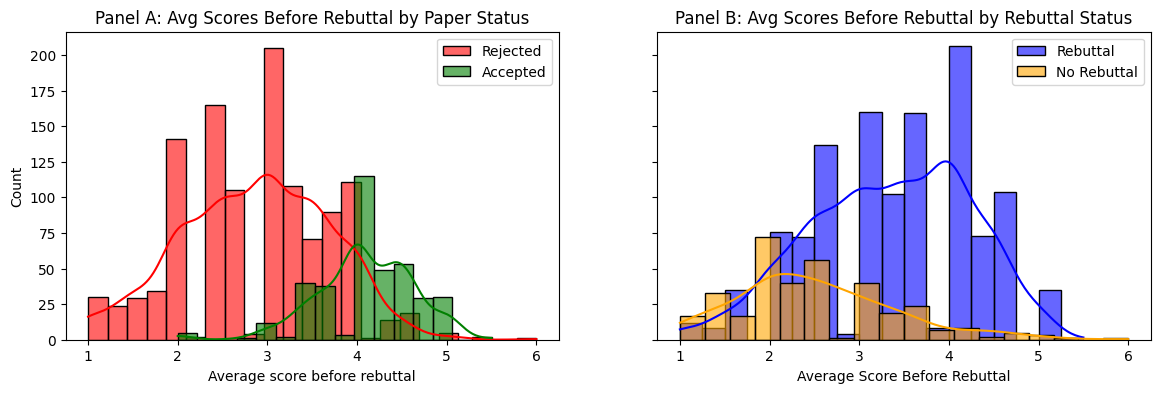

In [27]:
fig, ax = plt.subplots(figsize=(14,4), ncols=2, nrows=1, sharey=True)

rejected_papers = acl_reviews_df[acl_reviews_df['status'] == 'Reject']
accepted_papers = acl_reviews_df[acl_reviews_df['status'] == 'Accept']

rebuttal_papers = acl_reviews_df[acl_reviews_df['had_rebuttal'] == True]
no_rebuttal_papers = acl_reviews_df[acl_reviews_df['had_rebuttal'] == False]

sns.histplot(rejected_papers['overall_score_before_avg'], kde=True, ax=ax[0], label='Rejected', alpha=0.6, color='red')
sns.histplot(accepted_papers['overall_score_before_avg'], kde=True, ax=ax[0], label='Accepted', alpha=0.6, color='green')

ax[0].set_title('Panel A: Avg Scores Before Rebuttal by Paper Status')
ax[0].set_xlabel('Average score before rebuttal')
ax[0].legend()


sns.histplot(rebuttal_papers['overall_score_after_avg'], kde=True, ax=ax[1], label='Rebuttal', alpha=0.6, color='blue')
sns.histplot(no_rebuttal_papers['overall_score_after_avg'], kde=True, ax=ax[1], label='No Rebuttal', alpha=0.6, color='orange')

ax[1].set_title('Average scores after rebuttal')
ax[1].legend(['Rebuttal', 'No rebuttal'])
ax[1].set_title('Panel B: Avg Scores Before Rebuttal by Rebuttal Status')
ax[1].set_xlabel('Average Score Before Rebuttal')
ax[1].legend()

plt.show()

___

1. **Panel A: Average Scores Before Rebuttal by Paper Status**
   - This plot compares the distribution of average scores received before the rebuttal for papers that were eventually accepted (green) and those that were rejected (red).
   - Both distributions appear to be somewhat normally distributed. 
   - The green distribution (Accepted papers) generally has higher scores, indicating that papers with higher initial scores are more likely to be accepted.
   - The red distribution (Rejected papers) is skewed towards lower scores, reinforcing the correlation between lower initial scores and the likelihood of rejection.

2. **Panel B: Average Scores After Rebuttal by Rebuttal Status**
   - This plot shows the distribution of average scores received after the rebuttal, comparing papers that underwent a rebuttal process (blue) with those that did not (orange).
   - The blue distribution (Papers with rebuttal) indicates a broad range of scores, suggesting that rebuttals can lead to varied outcomes in terms of score changes.
   - The orange distribution (Papers without rebuttal) appears to have a narrower spread, which could imply less variability in scores when there is no rebuttal process involved.

These plots suggest that initial scores are indicative of the final decision (acceptance or rejection), and the rebuttal process may introduce variability in the final scores, potentially influencing the final decision on the papers.

**1.3** **/Discuss/:** If you know a paper had a rebuttal, is it more or less likely that it was accepted? Does this mean that rebuttals help papers get accepted? Explain why or why not, providing a concrete example.

___
Before answering this question we need to consider the following two factors **Correlation vs Causation** and **Selection Bias**:

- **Correlation vs Causation**: Knowing whether a paper had a rebuttal and was accepted, does not necessarily imply that the rebuttal caused the paper to be accepted. It is possible that the papers with rebuttals are more likely to be accepted but that might be due to other factors such as the quality of the paper (which increases the probability of acceptance and rebuttals $\rightarrow$ _third-cause fallacy_).

- **Selection Bias**: Papers that have rebuttabls might have been different in some way from the ones that didn't (e.g. different quality, controversial topic, etc.). Without controlling all the possible confounding factors, we cannot conclude that the rebuttals caused the paper to be accepted.

So in cocnlusion there may be some correlation between papers with rebuttals and papers that got accepted, but we cannot further analysis is needed in order to make more confident conclusions.
___

**1.4** Print the percentage of rebuttals per track in the conference (defined by the `track` column). 

**/Discuss:/** Using "the logic" of hypothesis testing (see slide 29 of Lecture 4), how would you devise a statistical test to refute the following null hypothesis: all tracks have the same fraction of papers with rebuttals. Your statistical test should consider all categories at once, rather than comparing the fraction of rebuttals between pairs of categories.

In [28]:
rebutals_per_track = acl_reviews_df.groupby('track')['had_rebuttal'].apply(lambda x: np.sum(x) / len(x)).reset_index()
display(rebutals_per_track)

,track,had_rebuttal
0,Dialogue and Interactive Systems,0.775281
1,Discourse and Pragmatics,0.804348
2,Document Analysis,0.730000
3,Generation,0.779661
4,Information Extraction and Text Mining,0.768362
5,Linguistic Theories Cognitive Modeling and Psy...,0.750000
6,Machine Learning,0.808696
7,Machine Translation,0.820755
8,Multidisciplinary and Area Chair COI,0.680000
9,Multilinguality,0.806452


**Discussion**:

To verify $H_0 = \{\text{all tracks have the same fraction of papers with rebuttals}\}$ we can use a $\chi^2$ test. Which is fit for categorical data and can be used to determine whether there is a significant association between two categorical variables. In this case `track` and `had_rebuttal`.

We can define it in the following way:
>$H_0$: The fraction of rebuttals is the same for all tracks.

>$H_1$: The fraction of rebuttals is not the same for all tracks.

## Task 2 (10pts): Prediction

You decide to investigate further the effect of rebuttals on acceptance using your machine learning skills.


**2.1** For each possible value in the `track` column, create a new column called {track}-onehot (e.g., for track=Generation, create Generation-onehot). Collectively, these new columns should "one hot-encode" the track column---for instance, if for a given paper the `track` column is filled with the value "Generation", the Generation-onehot column should equal 1 and all other {track}-onehot columns should equal 0. 

Print the column names of the resulting dataframe.

In [29]:
tracks = acl_reviews_df['track'].unique()

for track in tracks:
    acl_reviews_df[f'{track}-onehot'] = acl_reviews_df['track'].apply(lambda x: 1 if x == track else 0)

acl_reviews_df.head()

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,overall_score_after_std,Machine Learning-onehot,Question Answering-onehot,Multidisciplinary and Area Chair COI-onehot,Document Analysis-onehot,Word-level Semantics-onehot,Phonology Morphology and Word Segmentation-onehot,Textual Inference and Other Areas of Semantics-onehot,Information Extraction and Text Mining-onehot,Machine Translation-onehot,Dialogue and Interactive Systems-onehot,Linguistic Theories Cognitive Modeling and Psycholinguistics-onehot,Sentence-level semantics-onehot,Tagging Chunking Syntax and Parsing-onehot,Vision Robotics Multimodal Grounding and Speech-onehot,Resources and Evaluation-onehot,Sentiment Analysis and Argument Mining-onehot,Summarization-onehot,Discourse and Pragmatics-onehot,Generation-onehot,Multilinguality-onehot,Social Media-onehot
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,2.500000,0.500000,0.500000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.333333,3.333333,0.942809,0.942809,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,4.666667,4.666667,0.471405,0.471405,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.666667,0.816497,1.247219,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.500000,0.000000,0.500000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



**2.2** Create a column `had_rebuttal_int`, which equals 1 if the paper had a rebuttal, and 0 otherwise, and a column `accepted_int`, which equals 1 if the paper was accepted, and 0 otherwise. 

In [30]:
acl_reviews_df['had_rebuttal_int'] = acl_reviews_df['had_rebuttal'].apply(lambda x: 1 if x else 0)
acl_reviews_df['accept_int'] = acl_reviews_df['status'].apply(lambda x: 1 if x == 'Accept' else 0)

acl_reviews_df.head()

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,overall_score_after_std,Machine Learning-onehot,Question Answering-onehot,Multidisciplinary and Area Chair COI-onehot,Document Analysis-onehot,Word-level Semantics-onehot,Phonology Morphology and Word Segmentation-onehot,Textual Inference and Other Areas of Semantics-onehot,Information Extraction and Text Mining-onehot,Machine Translation-onehot,Dialogue and Interactive Systems-onehot,Linguistic Theories Cognitive Modeling and Psycholinguistics-onehot,Sentence-level semantics-onehot,Tagging Chunking Syntax and Parsing-onehot,Vision Robotics Multimodal Grounding and Speech-onehot,Resources and Evaluation-onehot,Sentiment Analysis and Argument Mining-onehot,Summarization-onehot,Discourse and Pragmatics-onehot,Generation-onehot,Multilinguality-onehot,Social Media-onehot,had_rebuttal_int,accept_int
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,2.500000,0.500000,0.500000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.333333,3.333333,0.942809,0.942809,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,4.666667,4.666667,0.471405,0.471405,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.666667,0.816497,1.247219,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.500000,0.000000,0.500000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


**2.3** Create a function `numpy_helper(df, cols)` to obtain a numpy.array out of your dataframe. The function should receive a dataframe `df` with N rows and a list of M columns `cols`, and should return a `np.array` of dimension `(NxM)` cast as a float.

In [31]:
def numpy_helper(df, cols):
    '''
    Obtain numpy.array out of the given df.
    df: dataframe of size (n, m)
    cols: list of column names of size p < m
    '''
    return df[cols].to_numpy()


**2.4**
Create:
- an array of features X containing all track one-hot features, as well as the `overall_score_before_avg`,`overall_score_before_std`, and `had_rebuttal_int`;
- an array of outcomes y containing `accepted_int`. 


Print the shapes of both X and y (e.g., `X.shape`).

In [32]:
tracks = acl_reviews_df['track'].unique()
cols = [f'{track}-onehot' for track in tracks]
cols += ['overall_score_before_avg', 'overall_score_before_std', 'had_rebuttal_int']

X = numpy_helper(acl_reviews_df, cols)
y = numpy_helper(acl_reviews_df, ['accept_int'])

print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')

X.shape: (1538, 24)
y.shape: (1538, 1)



**2.5** Build two `GradientBoostingClassifier` models using `sklearn` using the default parameters:
- Model 1: predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std`.
- Model 2:  predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std` **and** `had_rebuttal_int`.


For both models:

- Use the `cross_validate` function from `sklearn.model_selection` to compute the average precision, recall, and accuracy across test cross validation splits.

    - e.g., `cross_validate(clf, X, y, cv=30, scoring=('accuracy', 'precision', 'recall'))`

In [33]:
# Model 1
# one hot + scores before and after (no rebuttal)
cols_1 = [f'{track}-onehot' for track in tracks]
cols_1 += ['overall_score_before_avg', 'overall_score_before_std']
X_1 = numpy_helper(acl_reviews_df, cols_1)

# Model 2
# one hot + scores before and after + rebuttal
cols_2 = cols_1 + ['had_rebuttal_int']
X_2 = numpy_helper(acl_reviews_df, cols_2)

# Define models
model_1 = GradientBoostingClassifier()
model_2 = GradientBoostingClassifier()

# Cross validate
cv_results_1 = cross_validate(model_1, X_1, y.ravel(), cv=30, scoring=('accuracy', 'precision', 'recall'))
cv_results_2 = cross_validate(model_2, X_2, y.ravel(), cv=30, scoring=('accuracy', 'precision', 'recall'))


**2.6** Determine whether the difference in accuracy of the two models is statistically significant.


In [34]:
acc_model_1 = cv_results_1['test_accuracy']
acc_model_2 = cv_results_2['test_accuracy']


t_stat, p_val = stats.ttest_rel(acc_model_1, acc_model_2)

print(f'Accuracy of model 1: {np.mean(acc_model_1)}')
print(f'Accuracy of model 2: {np.mean(acc_model_2)}')
print(f'p-value: {p_val}')

Accuracy of model 1: 0.8373303167420816
Accuracy of model 2: 0.8386500754147814
p-value: 0.48357829299551125


The results of the paired t-test are as follows:
- The $p$-values is approximately 0.484
- The $p$-value is greater than the significance level of 0.05, therefore we cannot reject the null hypothesis that there is no difference in accuracy between the two models.
___

**2.7** Contrast the results obtained in **2.6** with what you observed in **Task 1**. What advantage did the analyses in **2.6** have?

### Conclusions

- The $p$-value ($0.48$) suggests that there is no statistically significant difference between the two models' accuracies. This indicates that including the `had_rebuttal_int` feature does not significantly impact the model's ability to predict paper acceptance.
- The close mean accuracies of both models further support this conclusion. The rebuttal feature does not seem to be a deciding factor in predicting acceptance when considering other features like the track and initial scores.
- This finding contrasts with the observations from Task 1, where the rebuttal process appeared to introduce variability in scores. However, when it comes to predicting acceptance, the rebuttal's impact may not be as significant as initially thought.
- The analysis in **2.6** provides a more quantifiable and statistically sound evaluation of the rebuttal's impact compared to the descriptive and observational analysis in **Task 1**.
___

## Task 3 (12pts): Interlude



**3.1** Using the formula API from `statsmodels`, estimate the following linear regression. Report the summary of the models.
- `accepted_int ~ had_rebuttal_int`,  
- `accepted_int ~ overall_score_after_avg`
- `had_rebuttal_int ~ overall_score_before_avg`

In [35]:
# Visualise latest dataframe
acl_reviews_df.head()

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,overall_score_after_std,Machine Learning-onehot,Question Answering-onehot,Multidisciplinary and Area Chair COI-onehot,Document Analysis-onehot,Word-level Semantics-onehot,Phonology Morphology and Word Segmentation-onehot,Textual Inference and Other Areas of Semantics-onehot,Information Extraction and Text Mining-onehot,Machine Translation-onehot,Dialogue and Interactive Systems-onehot,Linguistic Theories Cognitive Modeling and Psycholinguistics-onehot,Sentence-level semantics-onehot,Tagging Chunking Syntax and Parsing-onehot,Vision Robotics Multimodal Grounding and Speech-onehot,Resources and Evaluation-onehot,Sentiment Analysis and Argument Mining-onehot,Summarization-onehot,Discourse and Pragmatics-onehot,Generation-onehot,Multilinguality-onehot,Social Media-onehot,had_rebuttal_int,accept_int
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,2.500000,0.500000,0.500000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.333333,3.333333,0.942809,0.942809,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,4.666667,4.666667,0.471405,0.471405,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.666667,0.816497,1.247219,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.500000,0.000000,0.500000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [36]:
# Case 1: effect of rebuttal on acceptance
model_1 = smf.ols(formula='accept_int ~ had_rebuttal_int', data=acl_reviews_df).fit()

# Report summary
print(model_1.summary())


                            OLS Regression Results                            
Dep. Variable:             accept_int   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     66.22
Date:                Thu, 30 Nov 2023   Prob (F-statistic):           8.24e-16
Time:                        17:08:52   Log-Likelihood:                -855.16
No. Observations:                1538   AIC:                             1714.
Df Residuals:                    1536   BIC:                             1725.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0838      0.023  

In [37]:
# Case 2: effect of score after rebuttal on acceptance
model_2 = smf.ols(formula='accept_int ~ overall_score_after_avg', data=acl_reviews_df).fit()

# Report summary
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:             accept_int   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     1031.
Date:                Thu, 30 Nov 2023   Prob (F-statistic):          1.58e-173
Time:                        17:08:52   Log-Likelihood:                -492.65
No. Observations:                1538   AIC:                             989.3
Df Residuals:                    1536   BIC:                             1000.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [38]:
# Case 3: Effect of score before rebuttal on having a rebuttal
model_3 = smf.ols(formula='had_rebuttal_int ~ overall_score_before_avg', data=acl_reviews_df).fit()

# Report summary
print(model_3.summary())


                            OLS Regression Results                            
Dep. Variable:       had_rebuttal_int   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     240.2
Date:                Thu, 30 Nov 2023   Prob (F-statistic):           1.89e-50
Time:                        17:08:52   Log-Likelihood:                -727.42
No. Observations:                1538   AIC:                             1459.
Df Residuals:                    1536   BIC:                             1470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               


**3.2** **/Discuss:/** Interpret the coefficients associated with the binary independent variable in the above models. Note that independent variables are the ones on the right-handside of the equation.

- e.g., in `had_rebuttal_int ~ overall_score_before_avg`, `overall_score_before_avg` is the independent variable.



____
- `'accept_int ~ had_rebuttal_int’`: coeff = 0.2098, R2 = 0.041, p-value = 0.000, Intercept = 0.0838. So, we have:
    - $Acceptance = 0.0838 + 0.2098\cdot Rebuttal$.
    - Now, if a paper did not have a rebuttal i.e. rebuttal = 0, it means that the probability acceptance was 0.0838.
    - On the other hand, if rebuttal = 1, the probability of acceptance becomes 0.2936. This represents the expected change in the acceptance rate for a paper that had a rebuttal compared to one that did not, holding all else constant.
    - Our p-value is less than 0.05 which means that there’s sufficient evidence to reject the null hypothesis i.e. that the rebuttal has no effect on the acceptance.
    - The $R^2$ value is low ($R^2$ = 0.041). This means that the model explains only a small portion of the variance in the acceptance results. It is hence implied that other factors, not included in the models influence the outcome.
    - Note that the linear probability model (LPM) may not be the best model to use as it can predict probabilities outside the [0,1] range. This is because the LPM does not impose any restrictions on the predicted values. A logistic regression model may have been more appropriate. 
____


**3.3** **/Discuss:/** describe three correlations you can draw from the previous analysis. Describe their sign (i.e., whether they are positive or negative), and whether they are statistically significant (at the .05 level of significance).


___
1. **Positive Correlation between Rebuttal and Acceptance**: Indeed, the analysis shows a statistically significant positive correlation between having a rebuttal and the likelihood of acceptance. Specifically, the coefficient for `had_rebuttal_int` is 0.2098 (p-value < 0.05), indicating a strong effect. However the R-squared value (0.041) suggests that other variables also play a role in determining acceptance.
2. **Positive Correlation between Score After Rebuttal and Acceptance**: The score after rebuttal is a significant predictor of acceptance, with R-squared values indicating that a substantial proportion of variance in acceptance is explained by this variable (0.402). The coefficient in the model for `overall_score_after_avg` (0.2860) is positive and statistically significant (p-value < 0.05), highlighting the strength of this correlation.
3. **Positive Correlation between Score Before Rebuttal and Having a Rebuttal**: The analysis reveals a positive correlation between the score before rebuttal and the likelihood of having a rebuttal. The model shows a positive coefficient (0.1651) with statistical significance (p-value < 0.05). The R-square value, while modest (0.135), still suggests a reasonable degree of variance explanation.

___

**3.4** **/Discuss:/** Is the following statement True or False? Justify. 

- The variable `overall_score_after_avg` explains more of the variance in `accepted_int` than the variable `overall_score_before_avg` explains of `had_rebuttal_int`.


___
Ok, let's analyse what our $R^2$ values mean (in the logistic regressions):
- $R^2$ for `accept_int ~ overall_score_after_avg` = 0.402
- $R^2$ for `had_rebuttal_int ~ overall_score_before_avg` = 0.135.

Now the $R^2$ indicates the proportion of variance that is explained by our model. So, the first model explains 40.2% of the variance in the acceptance rate. On the other hand, the second model explains 13.5% of the variance in the rebuttal rate. So, in essence, the first model better explains the observed data than the second one. 

Hence, the statement is **True**.
___


**3.5** **/Discuss:/** Create a causal diagram relating the following variables:
- "Sa": `overall_score_after_avg`
- "Sb": `overall_score_before_avg`
- "Re": `had_rebuttal_int`
- "Ac": `accepted_int`
- "Tr": `track`


When unsure about whether a causal relationship exists, include it in the diagram. E.g., include the arrow corresponding to the key questions around this homework, i.e., `had_rebuttal_int`->`accepted_int`, even though you are investigating whether it exists. 

You may draw your diagram using text, use Sa/Sb/Re/Ac/Tr to represent the names of the variables, and simply indicate the causal links, one per line.


Instead of drawing something like this:
![](./dagv.jpeg)

Simply write:

- Tr->Sb
- Tr->Ac
- Tr->Re
- Ac->Sb
- Re->Sb
- Sb->Sa

---

___

**Track**:

Since we have not considered the potential influence of track on the other variables, we can assume it is likely it will affect all 4 of them:

- Tr -> Sb: The track of a paper might influence its initial score due to varying standards or expectations across different topics.
- Tr -> Re: Certain tracks might be more prone to debate or discussion, potentially affecting the likelihood of a rebuttal.
- Tr -> Sa: The track could influence the final score after rebuttal if certain topics are seen as more valuable or impactful.
- Tr -> Ac: The acceptance of a paper might be influenced by the track, possibly due to the popularity or relevance of the topic area.

**Score before rebuttal**:
- Sb -> Re: The initial score could influence whether the paper has a rebuttal judging by the positive correlation between the two variables.
- Sb -> Sa: The initial score is probably related to the final score after rebuttal. Logically, it would be surprising to see a paper with a very low score getting a very high one after rebuttal. 


**Having a rebuttal**:
- Re -> Sa: The purpose of a rebuttal is to address concerns and potentially improve the paper's score and improve the likelihood of acceptance.
- Re -> Ac: We saw a positive correlation between rebuttal and acceptance. Although it could be argued that rebuttal causes an increase in score leading to an improved Sa that is the real cause of the increase in Ac, it is also possible that the rebuttal itself is a factor in the decision to accept the paper. We would have to investigate whether there are papers that had a rebuttal but did not improve their score and were still accepted.

**Score after rebuttal**:
- Sa -> Ac: The final score after rebuttal likely influences the acceptance of the paper judging from the positive correlation between the two possibly repicting revised quality and response to feedback. 

___

**3.6** **/Discuss:/** What is the problem of simply comparing the outcomes of papers that had rebuttals with those that did not? Give a concrete example.

___

What is our goal here? To assess whether our 'treatment' i.e. having a rebuttal, causally affects the outcome i.e. acceptance. The problem is that although we indeed see a positive correlation between the two, we cannot be sure that a rebuttal directly causes an increase in acceptance. Indeed, several confounders could be influencing treatment assignment. 

The decision to have a rebuttal may be influenced by factors like the paper's track or its initial score. Indeed, we have already observed the positive correlation between the initial score and the likelihood of having a rebuttal. Consider, for instance, a high-quality paper that is marginally rejected. The authors of such a paper might be more motivated to write a rebuttal. In this case, the rebuttal is not the cause of the increase in acceptance, as the initial score introduces selection bias in our analysis. 

On the other hand, different tracks may be more prone to debate or discussion, or belong to rapidly evolving fields potentially affecting the likelihood of a rebuttal. In this case, the track is influencing the decision to have a rebuttal such that we cannot account for the effect of the rebuttal itself on the acceptance.

If we wanted to indeed assess the effect of the rebuttal, we could utilise methods like propensity score matching, considering the potential confounders (e.g. track, initial score or anything else), such that our 'treatmet' and 'control' groups are as similar as possible in all aspects except for the one we are interested in (i.e. the rebuttal). This way we could more accurately assess the true effect of the rebuttal.
___

# Task 4 (12 pts): Observational study

You decide to use your observational study skills to obtain a concrete answer to the question: do rebuttals increase acceptance?

 **4.1** Perform exact one-to-one matching considering the `score_before_avg` and the `track` variables. Each paper that had a rebuttal ("treatment group") should be matched to a paper that did not have a rebuttal ("control group"). 
- Your matching should be optimal, i.e., the maximum amount of papers possible must be matched. 
- Print the dataframe of papers in the matched sample

In [39]:
#get the key_count in order to match on this as well to avoid matching on the same paper
no_rebuttal_papers['key_count'] = no_rebuttal_papers.groupby(['overall_score_before_avg','track']).cumcount()
rebuttal_papers['key_count'] = rebuttal_papers.groupby(['overall_score_before_avg','track']).cumcount()

#use inner merge as we want 1:1 mathcing and validate to be sure that we have one_to_one matching
matched_merged = pd.merge(no_rebuttal_papers, rebuttal_papers, on = ['overall_score_before_avg', 'track', 'key_count'], how = 'inner', validate='one_to_one')
display(matched_merged)

C:\Users\stavr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\stavr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,tmp_id_x,status_x,submission_type_x,track,scores_before_x,scores_after_x,had_rebuttal_x,overall_score_before_avg,overall_score_after_avg_x,overall_score_before_std_x,overall_score_after_std_x,key_count,tmp_id_y,status_y,submission_type_y,scores_before_y,scores_after_y,had_rebuttal_y,overall_score_after_avg_y,overall_score_before_std_y,overall_score_after_std_y
0,P12,Reject,Long,Machine Translation,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,2.666667,2.666667,0.471405,0.471405,0,P320,Reject,Short,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.666667,0.471405,0.471405
1,P15,Reject,Long,Document Analysis,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,2.333333,2.333333,0.471405,0.471405,0,P97,Reject,Long,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.333333,0.471405,0.471405
2,P36,Reject,Long,Sentiment Analysis and Argument Mining,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,2.500000,2.500000,0.500000,0.500000,0,P506,Reject,Long,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,1.500000,1.500000,0.500000
3,P37,Reject,Long,Summarization,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,2.000000,0.000000,0.000000,0,P288,Reject,Short,"{'3': {'scores': {'originality': 3, 'soundness...","{'3': {'scores': {'originality': 3, 'soundness...",True,2.000000,0.000000,0.000000
4,P43,Accept,Long,Question Answering,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,4.000000,4.333333,0.816497,0.471405,0,P169,Reject,Long,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,4.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,P1528,Reject,Short,Machine Translation,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,2.500000,2.500000,0.500000,0.500000,1,P1133,Reject,Short,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.500000,0.500000,0.500000
267,P1535,Reject,Long,Sentence-level semantics,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",False,4.000000,4.000000,0.816497,0.816497,0,P40,Reject,Long,"{'2': {'scores': {'originality': 4, 'soundness...","{'2': {'scores': {'originality': 4, 'soundness...",True,4.000000,1.000000,1.000000
268,P1539,Reject,Short,Vision Robotics Multimodal Grounding and Speech,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.666667,2.666667,0.942809,0.942809,0,P606,Accept,Short,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.333333,1.699673,1.247219
269,P1542,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,2.000000,0.816497,0.816497,1,P938,Accept,Long,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.500000,0.000000,0.500000


In [40]:
#drop the columns that we mathced on
matched_merged_drop_keys = matched_merged.drop(columns=['track','overall_score_before_avg','key_count'])
#instead of having the matches side by side, we want to have them one on top of the other
data1= matched_merged_drop_keys.iloc[:,:9] #get the data for the control group
data2= matched_merged_drop_keys.iloc[:,9:] #get the data for the treatment group
data2.columns = data1.columns
#concatenate the two dataframes
matched_df = pd.concat([data1, data2], axis=0,ignore_index=True)
matched_df.head()

,tmp_id_x,status_x,submission_type_x,scores_before_x,scores_after_x,had_rebuttal_x,overall_score_after_avg_x,overall_score_before_std_x,overall_score_after_std_x
0,P12,Reject,Long,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,2.666667,0.471405,0.471405
1,P15,Reject,Long,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,2.333333,0.471405,0.471405
2,P36,Reject,Long,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,2.500000,0.500000,0.500000
3,P37,Reject,Long,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,0.000000,0.000000
4,P43,Accept,Long,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,4.333333,0.816497,0.471405
...,...,...,...,...,...,...,...,...,...
537,P1133,Reject,Short,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.500000,0.500000,0.500000
538,P40,Reject,Long,"{'2': {'scores': {'originality': 4, 'soundness...","{'2': {'scores': {'originality': 4, 'soundness...",True,4.000000,1.000000,1.000000
539,P606,Accept,Short,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.333333,1.699673,1.247219
540,P938,Accept,Long,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.500000,0.000000,0.500000


In [42]:
#add columns for the linear regression with integer values of had rebuttal and accepted
matched_df['had_rebuttal_int'] = matched_df['had_rebuttal_x'].apply(lambda x: 1 if x else 0)
matched_df['accept_int'] = matched_df['status_x'].apply(lambda x: 1 if x == 'Accept' else 0)
display(matched_df)

,tmp_id_x,status_x,submission_type_x,scores_before_x,scores_after_x,had_rebuttal_x,overall_score_after_avg_x,overall_score_before_std_x,overall_score_after_std_x,had_rebuttal_int,accept_int
0,P12,Reject,Long,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,2.666667,0.471405,0.471405,0,0
1,P15,Reject,Long,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,2.333333,0.471405,0.471405,0,0
2,P36,Reject,Long,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,2.500000,0.500000,0.500000,0,0
3,P37,Reject,Long,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,0.000000,0.000000,0,0
4,P43,Accept,Long,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,4.333333,0.816497,0.471405,0,1
...,...,...,...,...,...,...,...,...,...,...,...
537,P1133,Reject,Short,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.500000,0.500000,0.500000,1,0
538,P40,Reject,Long,"{'2': {'scores': {'originality': 4, 'soundness...","{'2': {'scores': {'originality': 4, 'soundness...",True,4.000000,1.000000,1.000000,1,0
539,P606,Accept,Short,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.333333,1.699673,1.247219,1,1
540,P938,Accept,Long,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.500000,0.000000,0.500000,1,1


**4.2** So far, we did not consider the `score_before_std` variable. One could argue that the variance in the scores makes a difference. E.g., a paper that received scores 1 and 5, might be very different from a paper with scores 3 and 3. 

Note that you did not match on the `score_before_std` variable. However, it suffices if this variable is "balanced" across treatment and control groups.
 Use the Standardized Mean Difference (SMD) to assess whether that's the case.

- The standardized mean difference for a variable $x$ and two groups $t$ and $c$ is defined as: $\frac{| E[x_t] - E[x_c] |}{\sqrt{Var[x_t] + Var[x_c]}}$

- Note that a Standardized Mean Difference smaller than 0.1 suggests that variables are balanced across treatment and control groups.


In [43]:
mean_no_rebuttal = matched_merged['overall_score_before_std_x'].mean() #get the mean of the control group
mean_rebuttal =matched_merged['overall_score_before_std_y'].mean() #get the mean of the treatment group
var_no_rebuttal = matched_merged['overall_score_before_std_x'].var() #get the variance of the control group
var_rebuttal = matched_merged['overall_score_before_std_y'].var() #get the variance of the treatment group
smd = np.abs(mean_no_rebuttal - mean_rebuttal) / np.sqrt(var_no_rebuttal + var_rebuttal) #calculate the standardized mean difference
print('Standardized mean difference: ', smd)    

Standardized mean difference:  0.045261849754418854


___

Since SMD is less than 0.1, the standard deviation variable is 'balanced' between treatment and control groups that suggests that the variance in the scores does not make a difference.

___


**4.3** Using the matched sample, estimate the following linear regression: `accepted ~ had_rebuttal_int`.


In [45]:
#Linear regression model
accepted_score_after = smf.ols('accept_int ~ C(had_rebuttal_int)', data = matched_df).fit()

print(accepted_score_after.summary())

                            OLS Regression Results                            
Dep. Variable:             accept_int   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                 6.877e-13
Date:                Thu, 30 Nov 2023   Prob (F-statistic):               1.00
Time:                        17:10:54   Log-Likelihood:                -124.36
No. Observations:                 542   AIC:                             252.7
Df Residuals:                     540   BIC:                             261.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               


**4.4** **/Discuss:/**

i. Considering your results obtained in 4.3, and the causal diagram drawn in Task 3: do rebuttals increase the chance of a paper getting accepted? Why are results different from what you obtained in **Task 1?**

ii. Why is there no need to include other covariates (e.g., score before) in the regression?

___

- i. **Linear Regression**: 'accept_int ~ had_rebuttal_int’: coeff = 3.123e-17, R2 = 0.000, p-value = 1.000, Intercept = 0.1033. So, we have:
    - $Acceptance = 0.1033 + 3.123e-17\cdot Rebuttal$.
    - If a paper did not have a rebuttal i.e. rebuttal = 0, it means that the average acceptance was 0.1033.
    - In this case, if rebuttal = 1, the average acceptance basically does not change at all. This represents the expected change in the acceptance rate for a paper that had a rebuttal compared to one that did not, holding all else constant.
    - The p-value is 1 which means that there’s not significant evidence to reject the null hypothesis i.e. that the rebuttal has no effect on the acceptance.
    - Rebuttals do not increase the chance of a paper getting accepted, which then suggests that the causal link Re -> Ac is not correct.
    - The acceptance chance of the papers is influenced by a lot of factors as shown in the causal diagram. Moreover, if the paper had a rebuttal can influence other factors that have a causal link with the acceptance chance. The results obtained here are different from what we observed in Task 1 as we excluded other confounders that influence both the the rebuttal chance and its acceptance, whereas in the observational analysis done in Task 1 we did not consider these effects.
- ii. There is no need to include other covariates in the regression because the samples have already been balanced. The exact one-to-one matching that was previously done, creates a dataset that has the exact same values between control and treatment groups in the confounders we mathced on.

___


**4.5** **/Discuss:/** Imagine there is another, unobserved variable "quality" which captures the true quality of the paper. Suppose quality ("Qu") is connected to the DAG you drew in the following ways:
- Qu -> Sa
- Qu -> Sb
- Qu -> Re
- Qu -> Ac
Assume that
- quality can only increase the chances of rebuttals;
- quality and the rebuttal can only increase the chance of a paper being accepted.
Does this uncontrolled confounder threaten the validity of your findings?


___
 
 - Generally, the uncontrolled confounder can threaten the validity of a finding as it influences both the treatment group and the outcome variable. For example if we have a high quality paper, there is going to be a higher chance that it had a rebuttal. In the same time there is going to be a higher change that the paper is going to be accepted. However, since it is an unobserved confounder there is no way to know if the higher chance of acceptance is due to the rebuttal or due to the higher quality of the paper. So, since the quality increases both the rebuttal and the acceptance chance, it could lead to a finding that shows that if the paper had a rebuttal it is more likely to be accepted (which could just be due to the fact that it was of higher quality).
 - More specifically, in this case however, since we showed that the rebuttals have no effect in the acceptance chance and the quality only gives a stronger positive effect of the rebuttals to the acceptance chance, then it should not threaten the validity of our outcome here. 
 ___
